<a href="http://agrum.org" target="blank"><img src="http://agrum.gitlab.io/theme/img/logoAgrum.png" align="left" style="height:100px"/></a><a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This pyAgrum's notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

import os

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain

gum.about()
gnb.configuration()


pyAgrum 0.22.1.9
(c) 2015-2021 Pierre-Henri Wuillemin, Christophe Gonzales

    This is free software; see the source code for copying conditions.
    There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  For details, see 'pyAgrum.warranty'.
    


Library,Version
OS,nt [win32]
Python,"3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]"
IPython,7.27.0
MatPlotLib,3.4.3
Numpy,1.21.2
pyAgrum,0.22.1.9


# Generating the database from a BN

In [3]:
bn=gum.loadBN("res/asia.bif")
bn

(pyAgrum.BayesNet<double>@0000024202AA6F60) BN{nodes: 8, arcs: 8, domainSize: 256, dim: 36}

In [4]:
gum.generateCSV(bn,"out/sample_asia.csv",500000,True)

out/sample_asia.csv: 100%|█████████████████████████████████|


Log2-Likelihood : -1615341.8988026057


-1615341.8988026057

In [5]:
with open("out/sample_asia.csv","r") as src:
    for _ in range(10):
        print(src.readline(),end="")

smoking,positive_XraY,dyspnoea,lung_cancer,visit_to_Asia,tuberculos_or_cancer,bronchitis,tuberculosis
1,1,1,1,1,1,1,1
1,1,0,1,1,1,0,1
1,1,1,1,1,1,1,1
1,0,0,1,1,1,0,1
1,1,1,1,1,1,1,1
0,1,1,1,1,1,1,1
1,1,0,1,1,1,0,1
0,1,0,1,1,1,0,1
0,1,1,1,1,1,1,1


In [6]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
print(learner)


Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : BDeu
Prior          : -



In [7]:
print(f"Row of visit_to_Asia : {learner.idFromName('visit_to_Asia')}") # first row is 0

Row of visit_to_Asia : 0


In [8]:
print(f"Variable in row 4 : {learner.nameFromId(4)}")

Variable in row 4 : lung_cancer


The BNLearner is capable of recognizing missing values in databases. For this purpose, just indicate as a last argument the list of the strings that represent missing values. 

In [9]:
# it is possible to add as a last argument a list of the symbols that represent missing values:
# whenever a cell of the database is equal to one of these strings, it is considered as a 
# missing value
learner=gum.BNLearner("res/asia_missing.csv",bn, ['?', 'N/A'] )
print(f"Are there missing values in the database ? {learner.state()['Missing values'][0]}")

Are there missing values in the database ? True


## type induction

When reading a csv file, BNLearner can try to find the correct type for discrete variable. Especially for numeric values.

In [10]:
%%writefile out/testTypeInduction.csv
A,B,C,D
1,2,0,hot
0,3,-2,cold
0,1,2,hot
1,2,2,warm

Writing out/testTypeInduction.csv


In [11]:
print("* by default, type induction is on (True) :")
learner=gum.BNLearner("out/testTypeInduction.csv")
bn3=learner.learnBN()
for v in sorted(bn3.names()):
    print(f"  - {bn3.variable(v)}")

print("")
print("* but you can disable it :")
learner=gum.BNLearner("out/testTypeInduction.csv",False)
bn3=learner.learnBN()
for v in sorted(bn3.names()):
    print(f"  - {bn3.variable(v)}")
   
print("") 
print("Note that when a Labelized variable is found, the labesl are alphabetically sorted.")

* by default, type induction is on (True) :
  - A:Range([0,1])
  - B:Range([1,3])
  - C:Integer(<-2,0,2>)
  - D:Labelized(<cold,hot,warm>)

* but you can disable it :
  - A:Labelized(<0,1>)
  - B:Labelized(<1,2,3>)
  - C:Labelized(<-2,0,2>)
  - D:Labelized(<cold,hot,warm>)

Note that when a Labelized variable is found, the labesl are alphabetically sorted.


# Parameters learning from the database

We give the $bn$ as a parameter for the learner in order to have the variables and the order of the labels for each variables. Please try to remove the argument $bn$ in the first line below to see the difference ...

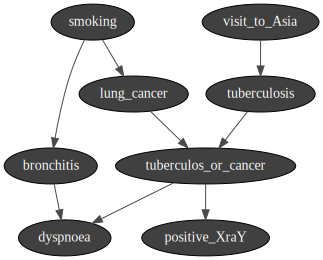

In [12]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables and labels
bn2=learner.learnParameters(bn.dag())
gnb.showBN(bn2)

In [13]:
from IPython.display import HTML

HTML('<table><tr><td style="text-align:center;"><h3>original BN</h3></td>'+
     '<td style="text-align:center;"><h3>Learned BN</h3></td></tr>'+
     '<tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('visit_to_Asia')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('visit_to_Asia')))
     +'</center></td></tr><tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('tuberculosis')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('tuberculosis')))
     +'</center></td></tr></table>')

# Structural learning a BN from the database

Note that, currently, the BNLearner is not yet able to learn in the presence of missing values. This is the reason why, when it discovers that there exist such values, it raises a gum.MissingValueInDatabase exception.

In [14]:
with open("res/asia_missing.csv","r") as asiafile:
    for _ in range(10):
        print(asiafile.readline(),end="")
try:
    learner=gum.BNLearner("res/asia_missing.csv",bn, ['?', 'N/A'] )
    bn2=learner.learnBN()
except gum.MissingValueInDatabase:
    print ( "exception raised: there are missing values in the database" )

smoking,lung_cancer,bronchitis,visit_to_Asia,tuberculosis,tuberculos_or_cancer,dyspnoea,positive_XraY
0,0,0,1,1,0,0,0
1,1,0,1,1,1,0,1
1,1,1,1,1,1,1,1
1,1,0,1,1,1,0,N/A
0,1,0,1,1,1,1,1
1,1,1,1,1,1,1,1
1,1,1,1,1,1,0,1
1,1,0,1,1,1,0,1
1,1,1,1,1,1,1,1
exception raised: there are missing values in the database


## Different learning algorithms

For now, there are three algorithms that are wrapped in pyAgrum : LocalSearchWithTabuList,

In [15]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()
print(learner)
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn2,explain.getInformation(bn2))
kl=gum.ExactBNdistance(bn,bn2)
kl.compute()


Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : Local Search with Tabu List
Tabu list size : 2
Score          : BDeu
Prior          : -

Learned in 136.5994ms


{'klPQ': 3.143704719349438e-05,
 'errorPQ': 0,
 'klQP': 2.882018810686671e-05,
 'errorQP': 128,
 'hellinger': 0.0033824658418710745,
 'bhattacharya': 5.71491205006694e-06,
 'jensen-shannon': 8.031135141830098e-06}

A greedy Hill Climbing algorithm (with insert, remove and change arc as atomic operations).

In [16]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()
print(learner)
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.sideBySide(bn2,explain.getInformation(bn2))

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : Greedy Hill Climbing
Score          : BDeu
Prior          : -

Learned in 93.4177ms


And a K2 for those who likes it :)

In [17]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useK2([0,1,2,3,4,5,6,7])
print(learner)
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
bn2

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : K2
K2 order       : visit_to_Asia, tuberculosis, tuberculos_or_cancer, positive_XraY, lung_cancer, smoking, bronchitis, dyspnoea
Score          : BDeu
Prior          : -

Learned in 45.429ms


(pyAgrum.BayesNet<double>@0000024202AA5DF0) BN{nodes: 8, arcs: 9, domainSize: 256, dim: 38}

K2 can be very good if the order is the good one (a topological order of nodes in the reference)


In [18]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useK2([7,6,5,4,3,2,1,0])
print(learner)
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
bn2

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : K2
K2 order       : dyspnoea, bronchitis, smoking, lung_cancer, positive_XraY, tuberculos_or_cancer, tuberculosis, visit_to_Asia
Score          : BDeu
Prior          : -

Learned in 0.0607677s


(pyAgrum.BayesNet<double>@0000024202AA63C0) BN{nodes: 8, arcs: 16, domainSize: 256, dim: 90}

# Following the learning curve

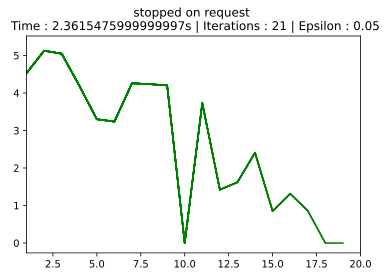

In [19]:
import numpy as np
%matplotlib inline

learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

# we could prefere a log2likelihood score
# learner.useScoreLog2Likelihood()
learner.setMaxTime(10)

# representation of the error as a pseudo log (negative values really represents negative epsilon
@np.vectorize
def pseudolog(x):
    seuil=2.0
    y=-x if x<0 else x
        
    if y<seuil:
        res=y*np.log10(seuil)/seuil
    else:
        res=np.log10(y)
        
    return res if x>0 else -res

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(3) # no more than 3 parent by node
gnb.animApproximationScheme(learner,
                            scale=pseudolog) # scale by default is np.log10

bn2=learner.learnBN()


# Customizing the learning algorithms

## 1. Learn a tree ?

In [20]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()

learner.setMaxIndegree(1) # no more than 1 parent by node
print(learner)
bntree=learner.learnBN()
bntree

Filename                : out/sample_asia.csv
Size                    : (500000,8)
Variables               : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types           : False
Missing values          : False
Algorithm               : Greedy Hill Climbing
Score                   : BDeu
Prior                   : -
Constraint Max InDegree : 1  (Used only for score-based algorithms.)



(pyAgrum.BayesNet<double>@0000024202AA9240) BN{nodes: 8, arcs: 7, domainSize: 256, dim: 30}

## 2. with prior structural knowledge

Filename                  : out/sample_asia.csv
Size                      : (500000,8)
Variables                 : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types             : False
Missing values            : False
Algorithm                 : Greedy Hill Climbing
Score                     : BDeu
Prior                     : -
Constraint Mandatory Arcs : {visit_to_Asia->tuberculosis, smoking->lung_cancer}



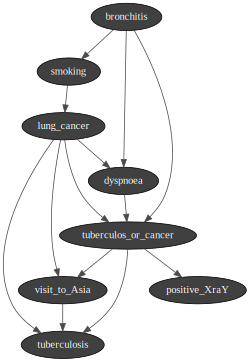

In [21]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc("smoking","lung_cancer") # smoking->lung_cancer
# I know that visit to Asia may change the risk of tuberculosis
learner.addMandatoryArc("visit_to_Asia","tuberculosis") # visit_to_Asia->tuberculosis
print(learner)
bn2=learner.learnBN()
gnb.showBN(bn2,size="5")

## 3. comparing BNs

In [22]:
help(gnb.getBNDiff)

Help on function getBNDiff in module pyAgrum.lib.notebook:

getBNDiff(bn1, bn2, size=None)
    get a HTML string representation of a graphical diff between the arcs of _bn1 (reference) with those of _bn2.
    
    * full black line: the arc is common for both
    * full red line: the arc is common but inverted in _bn2
    * dotted black line: the arc is added in _bn2
    * dotted red line: the arc is removed in _bn2
    
    :param BayesNet bn1: referent model for the comparison
    :param BayesNet bn2: bn compared to the referent model
    :param size: size of the rendered graph



In [23]:
gnb.sideBySide(bn,bn2,gnb.getBNDiff(bn,bn2),
              captions=['target','learned BN','graphical diffs between target and learned'])

target,learned BN,graphical diffs between target and learned


In [24]:
kl=gum.ExactBNdistance (bn,bn2)
kl.compute()

{'klPQ': 3.4775853616438404e-05,
 'errorPQ': 0,
 'klQP': 3.219079655995935e-05,
 'errorQP': 128,
 'hellinger': 0.0035500627699266694,
 'bhattacharya': 6.295850788054348e-06,
 'jensen-shannon': 8.86934938670321e-06}

## 4. changing the scores

By default, a BDEU score is used. But it can be changed.

In [25]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc(0,1)

# we prefere a log2likelihood score
learner.useScoreLog2Likelihood()

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(1) # no more than 1 parent by node
print(learner)
bn2=learner.learnBN()
kl=gum.ExactBNdistance(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

Filename                  : out/sample_asia.csv
Size                      : (500000,8)
Variables                 : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types             : False
Missing values            : False
Algorithm                 : Greedy Hill Climbing
Score                     : Log2Likelihood
Prior                     : -
Constraint Max InDegree   : 1  (Used only for score-based algorithms.)
Constraint Mandatory Arcs : {visit_to_Asia->tuberculosis}



## 5. Mixing algorithms

First we learn a structure with HillClimbing (faster ?)

In [26]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useGreedyHillClimbing()
learner.addMandatoryArc(0,1)
bn2=learner.learnBN()
kl=gum.ExactBNdistance(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

And then we refine with tabuList

In [27]:
learner=gum.BNLearner("out/sample_asia.csv",bn) #using bn as template for variables
learner.useLocalSearchWithTabuList()

learner.setInitialDAG(bn2.dag())
print(learner)
bn3=learner.learnBN()
kl=gum.ExactBNdistance(bn,bn3)
gnb.sideBySide(bn3,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

Filename       : out/sample_asia.csv
Size           : (500000,8)
Variables      : visit_to_Asia[2], tuberculosis[2], tuberculos_or_cancer[2], positive_XraY[2], lung_cancer[2], smoking[2], bronchitis[2], dyspnoea[2]
Induced types  : False
Missing values : False
Algorithm      : Local Search with Tabu List
Tabu list size : 2
Score          : BDeu
Prior          : -
Initial DAG    : True  (digraph {
     0;
     1;
     2;
     3;
     4;
     5;
     6;
     7;

     0 -> 1;
     6 -> 7;
     2 -> 3;
     6 -> 5;
     2 -> 1;
     2 -> 7;
     4 -> 1;
     4 -> 5;
     4 -> 2;
     4 -> 6;
     0 -> 2;
}

)



# Impact of the size of the database for the learning

In [28]:
import IPython.display
rows=3
sizes=[400,500,700,1000,2000,5000,
       10000,50000,75000,
       100000,150000,175000,
       200000,300000,500000]

def extract_asia(n):
    """
    extract n line from asia.csv to extract.csv
    """
    with open("out/sample_asia.csv","r") as src:
        with open("out/extract_asia.csv","w") as dst:
            for _ in range(n+1):
                print(src.readline(),end="",file=dst)

(400,8)
(500,8)
(700,8)
(1000,8)
(2000,8)
(5000,8)
(10000,8)
(50000,8)
(75000,8)
(100000,8)
(150000,8)
(175000,8)
(200000,8)
(300000,8)
(500000,8)


3.4728420731206205e-05


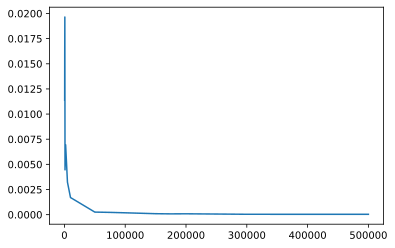

In [29]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    extract_asia(i)
    learner=gum.BNLearner("out/extract_asia.csv",bn) # using bn as template for variables
    learner.useGreedyHillClimbing()
    print(learner.state()["Size"][0])
    bn2=learner.learnBN()
    
    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3")+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"

IPython.display.display(IPython.display.HTML(res))

plot(sizes,l)
print(l[-1])

(400,8)
(500,8)
(700,8)
(1000,8)
(2000,8)
(5000,8)
(10000,8)
(50000,8)
(75000,8)
(100000,8)
(150000,8)
(175000,8)
(200000,8)
(300000,8)
(500000,8)


3.143704719349438e-05


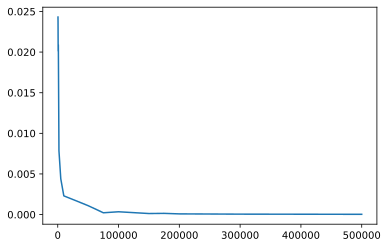

In [30]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    extract_asia(i)
    learner=gum.BNLearner("out/extract_asia.csv",bn) #using bn as template for variables
    learner.useLocalSearchWithTabuList()
    print(learner.state()["Size"][0])
    bn2=learner.learnBN()
    
    kl=gum.ExactBNdistance(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    bn2.setProperty("name","BN(%{0})".format(i))
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3")+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"

IPython.display.display(IPython.display.HTML(res))

plot(sizes,l)
print(l[-1])